# Project 3: Subreddit Classification with Pushshift API and NLP

## Part III - Modeling

Author: Charles Ramey

Date: 04/02/2023

---

#### Notebook Links

Part I - Project Intro & Data Cleaning
- [`Part-1_setup-and-cleaning.ipynb`](../code/Part-1_setup-and-cleaning.ipynb)

Part II - Exploratory Data Analysis (EDA)
- [`Part-2_eda.ipynb`](../code/Part-2_eda.ipynb)

Part IV - Conclusion, Recommendations, and Sources
- [`Part-4_conclusion-and-recommendations.ipynb`](../code/Part-4_conclusion-and-recommendations.ipynb)

### Contents

- [Data Import and Preprocessing](#Data-Import-and-Cleaning)
- [Modeling](#Modeling)

### Library Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
import xgboost as xg

import warnings

## Data Import and Preprocessing

### Data Import

In [2]:
df = pd.read_csv('../data/data_to_split.csv')

In [3]:
df.head(3), df.tail(3)

(  subreddit                                               text
 0    hockey  Does anyone know Jordan Staals take on Pride j...
 1    hockey  Elimination Clinching Scenarios Daily Free Tal...
 2    hockey  Is McDavid s Contract Worth It I m guessing hi...,
            subreddit                                               text
 62900  hockeyplayers  CCM P VS Bauer Easton E I m coming off the X a...
 62901  hockeyplayers  Got new skate forgot how to skate So I just go...
 62902  hockeyplayers  Frustrated at my skill level Hey all I started...)

### Preprocessing

Our data is mostly ready to use to train a classification model, we just need to take a couple preprocessing steps. First we'll encode the target classes (subreddit names) as 0s and 1s since some of our classification algorithms are designed to work with binary labels. Then we'll define our features, X, and target variable, y, for ease of use rather than calling the specific columns from the main dataframe each time we want to reference these features.

In [4]:
# Convert subreddit classes into binary labels
df['subreddit'] = df['subreddit'].apply(lambda x: 0 if x == 'hockey' else 1)

In [5]:
# X will be text, since that is what we're training our model on
# y will be the target we want to predict, 'subreddit'
X = df['text']
y = df['subreddit']

#### Baseline Accuracy

To give ourselves something to compare our model performance to, let's define the baseline accuracy. The baseline accuracy represents the proportion of the majority class. In this case, r/hockey submissions make up approximately 51% of the dataset, so a random guess would correctly classify a submission 51% of the time.

In [6]:
y.value_counts(normalize=True)

0    0.511534
1    0.488466
Name: subreddit, dtype: float64

#### Train-Test-Split

We'll split our data into a set to train the models on and a set to test model performance on using a train-test-split. For this project, we're training our models on 75% of the total available data. This comes out to just over 47,000 submissions randomly selected from both subreddits.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, stratify=y, random_state=42)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((47177,), (47177,), (15726,), (15726,))

---
## Modeling

In order for the models to work, the data needs to be count vectorized once more, so we'll refernce the stop words that were previously defined so that the models are not skewed by these common terms.

In [9]:
stopwords = ['the','to','and','http','www','com','in','com','of','for','it','subreddit',
            'is','on','with','that','at','this','have','but','be','en', 'pm','nd','st',
            'rd', 'if','are','so','can','from','id', 'hlslive', 'wsczoominwestus','wa',
            'jpg','pjpg','format','webp','png','doc','google','form', 's', 'link', 've']

#### Models to Test

Below are listed all of the classification machine learning models that will be tested to identify the model that achieves the greatest accuracy while also generalizing to the test data.

In [28]:
# Instantiation of models to test

# Logisitic Regression
logr = LogisticRegression(max_iter=10_00)

# Multinomial Naive Bayes
mnb = MultinomialNB()

# Decision Tree Classifier
dt = DecisionTreeClassifier()

# Random Forest Classifier
rf = RandomForestClassifier()

# Extra Trees Classifier
et = ExtraTreesClassifier()

# Adaptive Boost Classifier
ada = AdaBoostClassifier()

# Extreme Gradient Boost Classifier
xgb = xg.XGBClassifier()

In the cell below, we define the different hyperparamets that we want to test for each model. These will be referenced when we instantiate a grid search over the parameters for each model.

In [11]:
logr_params = {
    'cvec__max_features': [500, 1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2),(1,3)],
    'logr__C': [0.1,0.5]}

mnb_params = {
    'cvec__max_features': [500, 1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2), (1,3)]}

dt_params = {
    'cvec__max_features': [500,1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2),(1,3)],
    'dt__max_depth': [3,5],
    'dt__min_samples_split': [2,5,10]}

rf_params = {
    'cvec__max_features': [500,1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2),(1,3)],
    'rf__max_depth': [3,5],
    'rf__min_samples_split': [2,5,10]}
    
et_params = {
    'cvec__max_features': [500,1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2),(1,3)],
    'et__n_estimators': [50,100],
    'et__max_depth': [3,5],
    'et__min_samples_split': [2,5,10]}

ada_params = {
    'cvec__max_features': [500,1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2),(1,3)],
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [0.3,0.6]}

xgb_params = {
    'cvec__max_features': [500,1000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.95],
    'cvec__ngram_range': [(1,2),(1,3)],
    'xgb__n_estimators': [50,100],
    'xgb__learning_rate': [0.3,0.6]}

Here we define a function that will take all of the necessary inputs to define a pipeline with each estimator, instantiate a grid search for the best parameters, fit the best parameters to a model, and score the model's performance on the test data.

In [12]:
'''
Code adapted from Devin Faye, General Assembly
'''
def evaluation(X_train, y_train, X_test, y_test, model, model_name:str,
               model_params, scores_df=None):
    # If this is the first call of this function and a previous dataframe of scores
    # is not passed in the parameters, define a new dataframe to store model metrics
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['base_acc', 'train_acc', 'test_acc',
                                            'recall', 'precision', 'f1_score'])
    # instantiate a list to store the best parameters for the model
    # param_list = []
    # create a pipeline that will count vectorize the data and feed it into the selected model
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        (model_name, model)])
    # instantiate a grid search to pass the pipeline into with hyperparameters to search over
    gs = GridSearchCV(
        pipe,
        model_params,
        cv = 5, n_jobs=-1)
    # fit the model to the training data
    gs.fit(X_train, y_train)
    # generate a confusion matrix to visualize the model's performance
    ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues', normalize='true')
    # append the b
    # param_list.append(gs.best_params_)
    # print out the best hyperparameters for this model
    print(f"The best parameters for the {model_name} model are: {gs.best_params_}")
    
    # store the model's predicted values
    preds = gs.predict(X_test)
    
    # score the model using several metrics, baseline accuracy is included as a reference point
    base_acc = round(y.value_counts(normalize=True).max(), 2)
    train_acc = round(gs.score(X_train, y_train), 2)
    test_acc = round(gs.score(X_test, y_test), 2)
    rec = round(recall_score(y_test, preds), 2)
    prec = round(precision_score(y_test, preds), 2)
    fone = round(f1_score(y_test, preds), 2)
    
    # store the scores in the dataframe
    scores_df.loc[model_name,:] = [base_acc, train_acc, test_acc, rec, prec, fone]
    # make sure the scores are being stored as a dataframe
    scores_df = pd.DataFrame(scores_df)
    
    print('')
    print(scores_df)
    
    return scores_df

In the following cells, the function above is applied using the selected classification models listed above and the resulting scores are added to a dataframe the entirety of which is available after the final model is tested. A confusion matrix is used to interpret the results of each model. To aid with understanding the each confusion matrix, see the diagram below ([*source*](https://subscription.packtpub.com/book/big-data-and-business-intelligence/9781838555078/6/ch06lvl1sec34/confusion-matrix)).
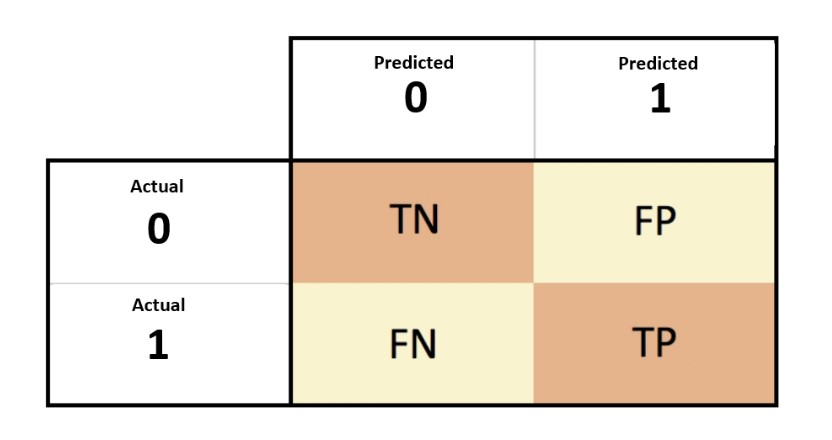
- **True Negative (TN)**: Classified as r/hockey, actually r/hockey
- **False Negative (FN)**: Classified as r/hockey, actually r/hockeyplayers
- **True Positive (TP)**: Classified as r/hockeyplayers, actually r/hockeyplayers
- **False Positive (FP)**: Classified as r/hockeyplayers, actually r/hockey

A breif explanation of the different reported metrics used to evaluate the models:
- **Training Accuracy (train_acc)**: Fraction of training submissions classified as the correct subreddit
- **Test Accuracy (test_acc)**: Fraction of test submissions classified as the correct subreddit
- **Recall (sensitivity)**: Proportion of actual positive cases correctly classified as positive (TP / TP+FN)
- **Precision**: Proportion of positive classifications that are actually positive (TP / TP+FP)
- **F1 Score**: Balance between precision and recall (2 * (prec*recall) / (prec + recall))

**Logistic Regression**

The best parameters for the logr model are: {'cvec__max_df': 0.95, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'logr__C': 0.5}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95


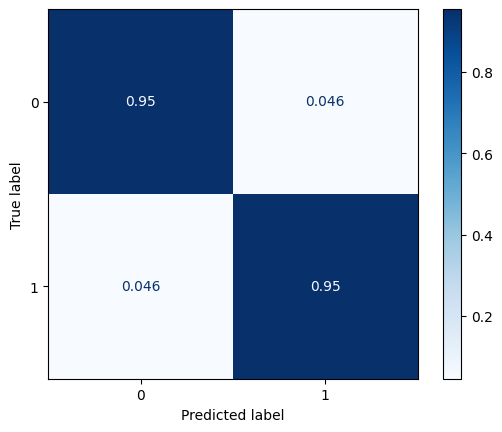

In [13]:
scores = evaluation(X_train, y_train, X_test, y_test, logr, 'logr',
                    logr_params)

Right off the bat, the Logistic Regression model performed extremely well, scoring over 0.95 on each of the five chosen metrics. Scores of 0.96 on the training data and 0.95 on the test data indicate that the model is low-bias, and low-variance. We will seek to improve on these scores and eliminate the difference between them with additional models, but these results are considered a success and this would work as an acceptable standalone model. From the confusion matrix, we can also see that the model also performed equally well when classifying submissions belonging to r/hockey and those belonging to r/hockeyplayers.

**Multinomial Naive Bayes**

The best parameters for the mnb model are: {'cvec__max_df': 0.95, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95
mnb      0.51      0.78     0.77   0.99      0.69     0.81


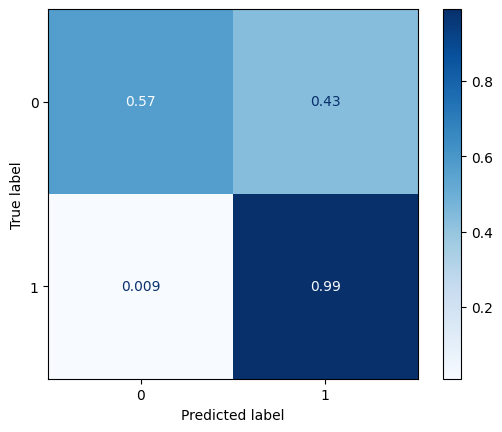

In [14]:
scores = evaluation(X_train, y_train, X_test, y_test, mnb, 'mnb',
                    mnb_params, scores_df=scores)

The Naive Bayes model exhibits a marked decrease in performance relative to the Logisitc Regression model. The model is still better than the baseline accuracy, low-variance, and generalizes well from the training data to the test data, however the model is high-bias and does not perform especially well in general. The confusion matrix tells us that the model is much better at classifying submissions that belong to r/hockeyplayers, but is hardly better than the baseline model when classifying submissions that belong to r/hockey. It's difficult to determine why this might be the case, but it's worth noting.

**Decision Trees Classifier**

The best parameters for the dt model are: {'cvec__max_df': 0.95, 'cvec__max_features': 500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3), 'dt__max_depth': 5, 'dt__min_samples_split': 2}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95
mnb      0.51      0.78     0.77   0.99      0.69     0.81
dt       0.51      0.86     0.86   0.78      0.91     0.84


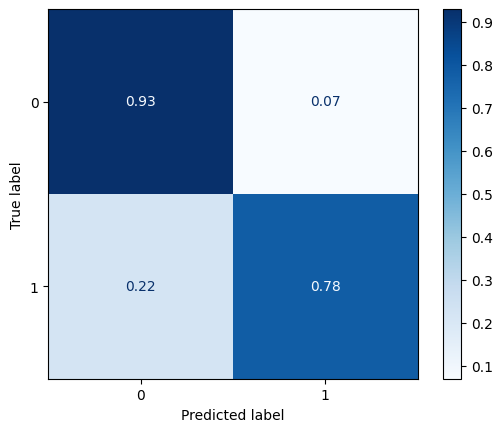

In [15]:
scores = evaluation(X_train, y_train, X_test, y_test, dt, 'dt',
                    dt_params, scores_df=scores)

The Decision Tree model scores better than the Naive Bayes models, but still not as well as the Logistic Regression model. Unlike the Naive Bayes model, this model's strength is in classifying submissions that belong to r/hockey, and performs worse than both prior models when classifying submissions that belong to r/hockeyplayers. With equal scores on both the training and test data, this model does generalize to new data the best so far.

**Random Forest Classifier**

The best parameters for the rf model are: {'cvec__max_df': 0.95, 'cvec__max_features': 500, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 3), 'rf__max_depth': 5, 'rf__min_samples_split': 5}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95
mnb      0.51      0.78     0.77   0.99      0.69     0.81
dt       0.51      0.86     0.86   0.78      0.91     0.84
rf       0.51      0.89     0.89   0.95      0.85      0.9


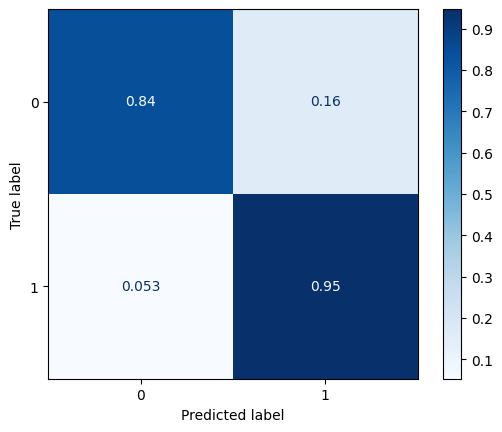

In [16]:
scores = evaluation(X_train, y_train, X_test, y_test, rf, 'rf',
                    rf_params, scores_df=scores)

The Random Forest model is an expected improvement on the Decision Tree model because it combines the predictions of multiple decision trees to achieve better performance. The model retains the ultra low-variance of the Decision Tree model while correctly classifying more submissions in both the training and test data. The model is preferential to submissions belonging to r/hockeyplayers, with a tendency to classify submissions as r/hockeyplayers despite belonging to r/hockey.

**Extra Trees Classifier**

The best parameters for the et model are: {'cvec__max_df': 0.95, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'et__max_depth': 5, 'et__min_samples_split': 10, 'et__n_estimators': 50}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95
mnb      0.51      0.78     0.77   0.99      0.69     0.81
dt       0.51      0.86     0.86   0.78      0.91     0.84
rf       0.51      0.89     0.89   0.95      0.85      0.9
et       0.51      0.68     0.67    1.0       0.6     0.75


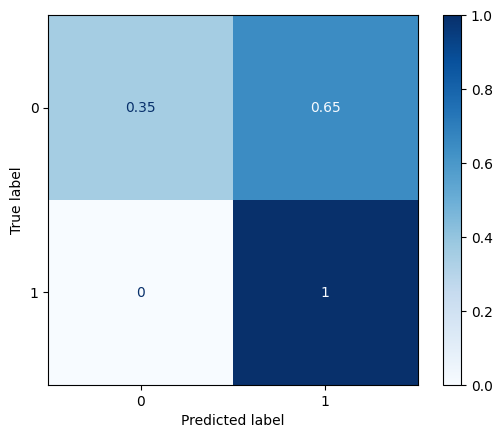

In [17]:
scores = evaluation(X_train, y_train, X_test, y_test, et, 'et',
                    et_params, scores_df=scores)

The Extra Trees model adds complexity and additional sampling randomness at each tree split, but the performance suffers in this case. The worst performing model thus far, the Extra Trees model remains low-variance but incorrectly classifies many more submissions than the previous models. This model is also highly biases towards r/hockeyplayers, classifying a lot of r/hockey submissions as belonging to r/hockeyplayers. For this particular use case, HFE does not benefit by biasing towards one subreddit or the other, as any misclassifications hinder the company's ability to accurately tune their marketing strategy.

**Adaptive Boost Classifier**

The best parameters for the ada model are: {'ada__learning_rate': 0.6, 'ada__n_estimators': 100, 'cvec__max_df': 0.95, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95
mnb      0.51      0.78     0.77   0.99      0.69     0.81
dt       0.51      0.86     0.86   0.78      0.91     0.84
rf       0.51      0.89     0.89   0.95      0.85      0.9
et       0.51      0.68     0.67    1.0       0.6     0.75
ada      0.51      0.94     0.94   0.93      0.94     0.94


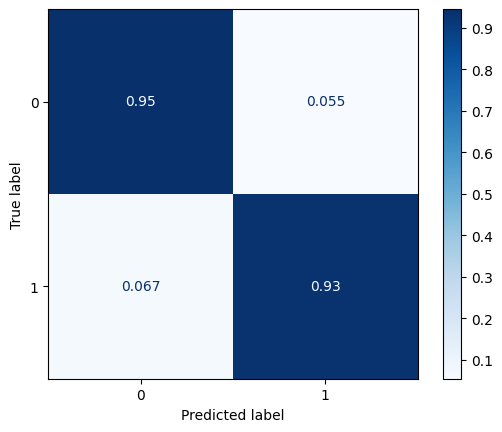

In [18]:
scores = evaluation(X_train, y_train, X_test, y_test, ada, 'ada',
                    ada_params, scores_df=scores)

The AdaBoost model doesn't perform quite as well as the Logistic Regression model, but improves upon all of the other models. This model, which works by training intentionally weak models and then learning from their mistakes, could be preferential to the Logistic Regression model due to its high accuracy combined with a complete reduction of variance. We will seek to improve on both the Logisitc Regression model and AdaBoost model with the final model.

**Extreme Gradient Boost Classifier**

The best parameters for the xgb model are: {'cvec__max_df': 0.95, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'xgb__learning_rate': 0.3, 'xgb__n_estimators': 100}

     base_acc train_acc test_acc recall precision f1_score
logr     0.51      0.96     0.95   0.95      0.95     0.95
mnb      0.51      0.78     0.77   0.99      0.69     0.81
dt       0.51      0.86     0.86   0.78      0.91     0.84
rf       0.51      0.89     0.89   0.95      0.85      0.9
et       0.51      0.68     0.67    1.0       0.6     0.75
ada      0.51      0.94     0.94   0.93      0.94     0.94
xgb      0.51      0.97     0.95   0.95      0.95     0.95


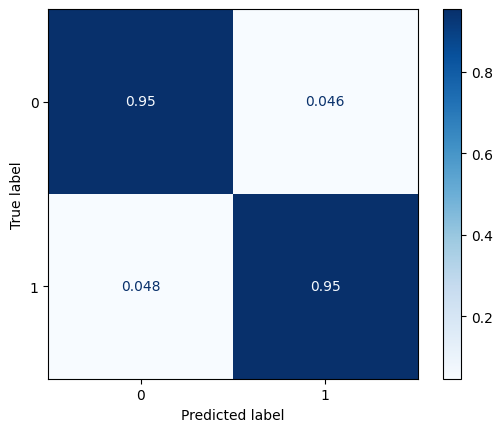

In [19]:
scores = evaluation(X_train, y_train, X_test, y_test, xgb, 'xgb',
                    xgb_params, scores_df=scores)

While the XGBoost model has the best accuracy among all models on both the training and test data, it has the largest variance of all tested models. In order to have the most confidence in the company's model, a primary goal is to retain low variance.

We could choose to select and use either the Logistic Regression or AdaBoost model at this point, however we'll test one more option for creating the best possible model. In the cells below, we stack all of the models using the bets hyperparameters for each. By stacking, we can train one of our best models on the predictions of all other models in an attempt to learn from the successes and failures of each model. Thus we will generate predictions with each model, then retrain the Logistic Regression model on the predictions and evaluate the results.

In [20]:
logr_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=1000,
        min_df=3,
        max_df=0.95,
        ngram_range=(1,2))),
    ('logr', LogisticRegression(
        max_iter=10_000,
        C=0.1))])

mnb_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=1000,
        min_df=3,
        max_df=0.95,
        ngram_range=(1,2))),
    ('mnb', MultinomialNB())])

dt_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=1000,
        min_df=3,
        max_df=0.95,
        ngram_range=(1,2))),
    ('dt', DecisionTreeClassifier(
        max_depth=5,
        min_samples_split=2))])

rf_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=500,
        min_df=2,
        max_df=0.95,
        ngram_range=(1,2))),
    ('rf', RandomForestClassifier(
        max_depth=5,
        min_samples_split=2))])

et_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=1000,
        min_df=3,
        max_df=0.95,
        ngram_range=(1,2))),
    ('et', ExtraTreesClassifier(
        max_depth=5,
        min_samples_split=2,
        n_estimators=50))])

ada_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=1000,
        min_df=2,
        max_df=0.95,
        ngram_range=(1,2))),
    ('ada', AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.6))])
    
xgb_pipe = Pipeline([
    ('cvec', CountVectorizer(
        max_features=1000,
        min_df=2,
        max_df=0.95,
        ngram_range=(1,2))),
    ('xgb', xg.XGBClassifier(
        n_estimators=100,
        learning_rate=0.3))])

In [21]:
X_pred_train = pd.DataFrame()
X_pred_train['logr'] = cross_val_predict(logr_pipe, X_train, y_train)
X_pred_train['mnb'] = cross_val_predict(mnb_pipe, X_train, y_train)
X_pred_train['dt'] = cross_val_predict(dt_pipe, X_train, y_train)
X_pred_train['rf'] = cross_val_predict(rf_pipe, X_train, y_train)
X_pred_train['et'] = cross_val_predict(et_pipe, X_train, y_train)
X_pred_train['ada'] = cross_val_predict(ada_pipe, X_train, y_train)
X_pred_train['xgb'] = cross_val_predict(xgb_pipe, X_train, y_train)

In [22]:
X_pred_train.head()

,logr,mnb,dt,rf,et,ada,xgb
0,1,1,1,1,1,1,1
1,0,0,0,0,1,0,0
2,0,1,0,0,1,0,0
3,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1


In [23]:
logr_pipe.fit(X_train, y_train)
mnb_pipe.fit(X_train, y_train)
dt_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
et_pipe.fit(X_train, y_train)
ada_pipe.fit(X_train, y_train)
xgb_pipe.fit(X_train, y_train);

In [29]:
logr.fit(X_pred_train, y_train)

LogisticRegression(max_iter=1000)

In [30]:
X_pred_test = pd.DataFrame()
X_pred_test['logr'] = logr_pipe.predict(X_test)
X_pred_test['mnb'] = mnb_pipe.predict(X_test)
X_pred_test['dt'] = dt_pipe.predict(X_test)
X_pred_test['rf'] = rf_pipe.predict(X_test)
X_pred_test['et'] = et_pipe.predict(X_test)
X_pred_test['ada'] = ada_pipe.predict(X_test)
X_pred_test['xgb'] = xgb_pipe.predict(X_test)

In [34]:
print(f"Baseline accuracy: {round(y.value_counts(normalize=True).max(), 2)}")
print(f"Training accuracy: {round(logr.score(X_pred_train, y_train), 2)}")
print(f"Test accuracy: {round(logr.score(X_pred_test, y_test), 2)}")
print(f"Recall: {round(recall_score(y_test, logr.predict(X_pred_test)), 2)}")
print(f"Precision: {round(precision_score(y_test, logr.predict(X_pred_test)), 2)}")
print(f"F1 Score: {round(f1_score(y_test, logr.predict(X_pred_test)), 2)}")

Baseline accuracy: 0.51
Training accuracy: 0.95
Test accuracy: 0.95
Recall: 0.96
Precision: 0.95
F1 Score: 0.95


After stacking and retraining our Logisitic Regression model on the predicitons of the full set of models, we end with a model that can classify submissions to the correct subreddit with 95% accuracy on both the training data and test data, while also achieving a complete reduction of variance. This model is expected to meet the needs of HFE and satisfy the goal of this project.